# Lux AI Season 2 @NeurIPS'23 Tutorial - Python Kit

Welcome to Lux AI Season 2!

This notebook is the basic setup to use Jupyter Notebooks and the kaggle-environments package to develop your bot. If you plan to not use Jupyter Notebooks or any other programming language, please see our Github. The following are some important links!

Competition Page: https://www.kaggle.com/competitions/lux-ai-season-2-neurips-stage-2/

Online Visualizer: https://s2vis.lux-ai.org/

Specifications: https://www.lux-ai.org/specs-s2

Github: https://github.com/Lux-AI-Challenge/Lux-Design-S2

Bot API: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits

And if you haven't done so already, we highly recommend you join our Discord server at https://discord.gg/aWJt3UAcgn or at the minimum follow the kaggle forums at https://www.kaggle.com/c/lux-ai-season-2/discussion. We post important announcements there such as changes to rules, events, and opportunities from our sponsors!

Now let's get started!

## Prerequisites
We assume that you have a basic knowledge of Python and programming. It's okay if you don't know the game specifications yet! Feel free to always refer back to https://www.lux-ai.org/specs-s2.

## Basic Setup
First thing to verify is that you have python 3.7 or above and have the [luxai_s2](https://pypi.org/project/luxai_s2/) package installed. Run the command below to do so. If you are using Kaggle Notebooks, **make sure to also click run-> restart and clear cell outputs** on the top right next to view and add-ons. (This fixes a bug where Kaggle Notebooks loads an incompatible package)

In [1]:
from IPython.display import clear_output as clr
!pip install numpy==1.25.2 # to install distrax and gymnax
!pip install distrax
clr()

In [2]:
# !git clone -b ippoga-patch-1 https://github.com/ippoga/jux.git ./jux_i

In [3]:
# # we need to use a lower version of jax for environment generation. Does not affect normal RL inference code
# %pip install --upgrade "jax[cuda11_cudnn82]==0.4.7" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# # install the package. For now this is from source, the final pypi package will be released soon
# !pip install /kaggle/working/jux_i
# %pip install git+https://github.com/RoboEden/jux.git@dev
# rich is needed by this tutorial for nice printing
%pip install rich
# clr()

Note: you may need to restart the kernel to use updated packages.


In [4]:
!cp -r ../input/single-savetest0-4/* .

In [5]:
# verify version
!python --version
!pip install --upgrade luxai_s2
!cp -r ../input/lux-ai-season-2-neurips-stage-2/* .

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 47.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.8/840.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 39.2 MB/s eta 0:00:00
  Created wheel for vec-noise: filename=vec_noise-1.1.4-cp310-cp310-linux_x86_64.whl size=35371 sha256=62ea1217078b43ad08c80083a75278f64ddf0fb18eb63a149855db9b8ea92628
  Stored in directory: /root/.cache/pip/wheels/2b/28/e4/f710af1a5bb24bb6da3d4f65081e268ca85034b7ac0a9237fe
Successfully built vec-noise
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3


In [6]:
# !pip install jax==0.4.14 # for orbax.checkpoint and jux avoiding restart
# clr()

In [5]:
from luxai_s2.env import LuxAI_S2
import matplotlib.pyplot as plt
import numpy as np

We can now create an environment and start interacting with it, as well as look at what the observation is like

In [6]:
env = LuxAI_S2() # create the environment object
obs, _ = env.reset(seed=41) # resets an environment with a seed

In [7]:
# the observation is always composed of observations for both players.
obs.keys(), obs["player_0"].keys()

(dict_keys(['player_0', 'player_1']),
 dict_keys(['units', 'teams', 'factories', 'board', 'real_env_steps', 'global_id']))

To visualize the environment, on jupyter notebooks you have two options

With the `rgb_array` mode you can visualize every step as an environment episode progresses. 

With the CLI tool, you can run an episode and save a replay.json to upload to https://s2vis.lux-ai.org/ or a replay.html file to directly open and watch

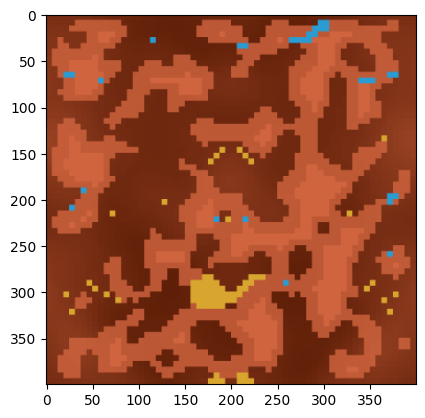

In [8]:
# visualize the environment so far with rgb_array to get a quick look at the map
# dark orange - high rubble, light orange - low rubble
# blue = ice, yellow = ore
img = env.render()
plt.imshow(img)

## Building an Agent
Now we know what the environment looks like, let's try building a working agent. The goal of this environment to ensure at least one factory stays alive by the end of the episode and grow as much lichen as possible.

In our kit we provide a skeleton for building an agent. Avoid removing any function from the kit unless you know what you are doing as it may cause your agent to fail on the competition servers. This agent defintion should be stored in the `agent.py` file.

The agent will have `self.player, self.opp_player, self.env_cfg` populated with the correct values at each step of an environment during competition or when you use the CLI tool to run matches. 

`self.env_cfg` stores the curent environment's configurations, and `self.player, self.opp_player` stores the name of your player/team and the opposition respectively (will always be "player_0" or "player_1").

In [9]:
from lux.kit import obs_to_game_state, GameState, EnvConfig
from luxai_s2.utils import animate
from lux.utils import direction_to, my_turn_to_place_factory
class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        # optionally convert observations to python objects with utility functions
        game_state = obs_to_game_state(step, self.env_cfg, obs) 
        return actions

    def act(self, step: int, obs, env, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        return actions

Note that in the environment, there are two distinct phases of the game where you will have to program two different sets of logic to play it.

We will also define a simple function to initialize our agent and interact with the environment and generate a simple video replay.
No need to worry about how this works specifically, you can copy paste this as you see fit. Note that this is a simplified representation. In order to visually see all numbers and details about units, factories etc. use our web visualizer.

In [10]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs, _ = env.reset()
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].early_setup(step, o)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render()]
#         print(termination)
        dones = {k: terminations[k] or truncations[k] for k in terminations}
    done = False
    while not done:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o, env)
            actions[player] = a
        step += 1
        obs, rewards, terminations, truncations, infos = env.step(actions)
        imgs += [env.render()]
        dones = {k: terminations[k] or truncations[k] for k in terminations}
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

### Early Phase

During the first turn of the game, each player is given the map, starting resources (N factories and N\*150 water and ore), and are asked to bid for who goes first/second. Each 1 bid removes 1 water and 1 ore from that player's starting resources. Each player responds in turn 1 with their bid, which can be positive to prefer going first or negative to prefer going second. 

After bidding you then place each of your factories. Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team which account for the opponent's factories and resource tiles which you can't spawn on.

We will write a simple `early_setup` function to return the appropriate action to handle this phase.



In [11]:
def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
    if step == 0:
        # bid 0 to not waste resources bidding and declare as the default faction
        # you can bid -n to prefer going second or n to prefer going first in placement
        return dict(faction="AlphaStrike", bid=0)
    else:
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        # factory placement period
        
        # how much water and metal you have in your starting pool to give to new factories
        water_left = game_state.teams[self.player].water
        metal_left = game_state.teams[self.player].metal
        
        # how many factories you have left to place
        factories_to_place = game_state.teams[self.player].factories_to_place
        # whether it is your turn to place a factory
        my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
        if factories_to_place > 0 and my_turn_to_place:
            # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
            potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
            spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
            return dict(spawn=spawn_loc, metal=150, water=150)
        return dict()
Agent.early_setup = early_setup

Each team gets `N` factories to place, with. For conveniency the observation contains all possible spawn locations for your team

In [12]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 15)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Congratz, we have lift off! We got both teams to spawn some factories. With the early phase over, we can now start programming the logic to power the next phase.

### Regular Phase

The goal of the game is to grow more lichen than your opponent by the end of the 1000 step episode (not including early phase steps). To grow lichen factories must consume water. Moreover, factories passively consume 1 water a turn, and you must ensure at least one factory survives until the end. Whichever team loses all their factories first will automatically lose. 

To obtain water, robots/units must mine ice from ice tiles (blue on the map) and deliver them back to a factory which then automatically refines ice into water. 

Moreover, to help us write better code, we will use the provided function `obs_to_game_state` to convert observations from raw dictionaries to interactable python objects. Finally, we will also use a provided `animate` function to easily generate a simple video of the episode and embed it into here without having to upload a replay file to the web visualizer.

#### Building Robots

Only factories can build robots, so for each factory on our team, if there is enough metal and power, we will issue a command to build a new heavy robot.

More advanced strategies will be able to efficiently leverage light units as well to collect resources but for simplicity, this tutorial uses heavy robots since they don't need to move as often to collect many resources but can collect many at a time.

In [13]:
from lux.kit import obs_to_game_state, GameState
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state: GameState = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
    return actions
Agent.act = act

In [14]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 25)

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Robots built, but they're idle! Let's get them to work.

#### Moving Robots and Mining

We want the robots to find the closest ice tile and mine it.
We'll worry about delivering the ice back home later. Let's update our `act` function to add this functionality. We will iterate over all our units and find the closest ice tile. Then we will use a given utility function that gives us the direction that takes us towards the desired ice tile. Lastly, we check if we have enough power to move and can move in that direction and submit that action.

Importantly, in this season **units are given action queues (a list of actions). Each time an action queue is given, the unit's old action queue is replaced completely in addition to a small additional action queue submission power cost.**

Moreover, each action has two other attributes, its execution count `n` and `repeat`. Each time the action is succesfully executed, we decrement `n` by 1. If `n` hits 0, we remove the action from the action queue. If `repeat == 0`, then we don't recycle the action. If `repeat > 0`, then we **recycle the same action to the back of the action queue** but this time with `n = repeat`.

For this tutorial, we will be giving units one action at a time with no action recycling or multiple executions. For more advanced competitors, to reduce power costs you may want to submit longer action queues and only update the action queue every once in a while.

In [15]:
from lux.utils import direction_to
import sys
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
            
    # iterate over our units and have them mine the closest ice tile
    units = game_state.units[self.player]
    ice_map = game_state.board.ice # flip the board as it stores by rows then columns
    ice_tile_locations = np.argwhere(ice_map == 1) # numpy magic to get the position of every ice tile
    for unit_id, unit in units.items():
        # compute the distance to each ice tile from this unit and pick the closest
        ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
        closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
        
        # if we have reached the ice tile, start mining if possible
        if np.all(closest_ice_tile == unit.pos):
            if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.dig(repeat=0, n=1)]
        else:
            direction = direction_to(unit.pos, closest_ice_tile)
            move_cost = unit.move_cost(game_state, direction)
            # check move_cost is not None, meaning that direction is not off the map or blocked
            # check if unit has enough power to move in addition to updating the action queue.
            if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
                actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
        # since we are using the simple embedded visualizer, we will have to print out details about units
        # importantly, note that we print with file=sys.stderr. Printing with anything will cause your agent to fail
        if unit.cargo.ice > 50:
            print(game_state.real_env_steps, unit, f"has {unit.cargo.ice} ice", file=sys.stderr)
    return actions
Agent.act = act

In [16]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=40)

8 [0] unit_12 HEAVY at [54 19] has 60 ice
9 [0] unit_12 HEAVY at [54 19] has 80 ice
9 [0] unit_15 HEAVY at [21 12] has 60 ice
10 [0] unit_12 HEAVY at [54 19] has 100 ice
10 [0] unit_15 HEAVY at [21 12] has 80 ice
11 [0] unit_12 HEAVY at [54 19] has 100 ice
11 [0] unit_15 HEAVY at [21 12] has 100 ice
12 [0] unit_12 HEAVY at [54 19] has 120 ice
12 [0] unit_15 HEAVY at [21 12] has 100 ice
12 [1] unit_22 HEAVY at [42 45] has 60 ice
13 [0] unit_12 HEAVY at [54 19] has 120 ice
13 [0] unit_14 HEAVY at [10 59] has 60 ice
13 [0] unit_15 HEAVY at [21 12] has 100 ice
13 [1] unit_22 HEAVY at [42 45] has 60 ice
14 [0] unit_12 HEAVY at [54 19] has 120 ice
14 [0] unit_14 HEAVY at [10 59] has 60 ice
14 [0] unit_15 HEAVY at [21 12] has 100 ice
14 [1] unit_22 HEAVY at [42 45] has 60 ice
15 [0] unit_12 HEAVY at [54 19] has 120 ice
15 [0] unit_14 HEAVY at [10 59] has 60 ice
15 [0] unit_15 HEAVY at [21 12] has 100 ice
15 [0] unit_16 HEAVY at [40 41] has 60 ice
15 [1] unit_22 HEAVY at [42 45] has 60 ice
16 

And they're off! The heavy robots have started to move towards the ice tiles and some have begun mining.

#### Delivering Resources and Keep Factories Alive
We now have ice being mined, but we now need to deliver that back to the factories so they can refine that ice into water and sustain themselves.

In [17]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import distrax
import gym

In [18]:
class SELayer(nn.Module):
    channel: int
    reduction: int = 4#16

    @nn.compact
    def __call__(self, x):
        b, h, w, c = x.shape
        y = jnp.mean(x, axis=(-3, -2), keepdims=True)
        y = nn.Dense(self.channel // self.reduction, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.relu(y)
        y = nn.Dense(self.channel, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.sigmoid(y)
        y = jnp.transpose(y,(0,3,1,2))
        y = jnp.tile(y,(h,w))
        y = jnp.transpose(y,(0,2,3,1))
        return x * y


class ResidualBlock(nn.Module):
    in_channel: int
    out_channel: int
    kernel_size: int = 5
    padding: int = 2

    @nn.compact
    def __call__(self, x):
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(x)
        left = nn.leaky_relu(left)
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(left)
        left = nn.leaky_relu(left)
        selayer = SELayer(self.out_channel)
        out = selayer(left)
        out = out + x
        out = nn.leaky_relu(out)
        return out


class Net(nn.Module):
    features: int
    num_act: int

    @nn.compact
    def __call__(self, map_feature, unit_pos):
        B, H, W, C = map_feature.shape
        n_mask = C - self.features
        action_mask = map_feature[:,:,:,-n_mask:]
        map_feature = map_feature[:,:,:,:-n_mask]
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(map_feature)
        x = nn.leaky_relu(x)
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)

        for _ in range(4):
            x = ResidualBlock(self.features, self.features)(x)

#         if config["BATCH_NORM"]:
        BN = nn.BatchNorm(use_running_average=False)
        variables = BN.init(jax.random.split(rng)[0], x)
        x,_ = BN.apply(variables,x,mutable=['batch_stats'])
            
        actor_mean = x.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = nn.Conv(
            features=self.num_act, kernel_size=(1,1), kernel_init=orthogonal(np.sqrt(2))
        )(actor_mean)
        action_mask = action_mask.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = actor_mean - action_mask
        pi = distrax.Categorical(logits=actor_mean)
        x = nn.Conv(features=self.features, kernel_size=(1, 1), kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)
        critic_value = nn.Conv(features=1, kernel_size=(1, 1))(x)
        critic_value = jnp.mean(critic_value, axis=(-3, -2, -1))

        return pi, critic_value


In [24]:
def obsv_from_state(env_state, obs):
    facocc_map = env_state.board.factory_occupancy_map
    facocc_map = jnp.where(facocc_map==-1,127,facocc_map)
    fac_id = obs['teams']['player_0']['factory_strains']
    enemy_fac_id = obs['teams']['player_1']['factory_strains']
    def new_facocc_map_fn(facocc_map, fac_id):
        def new_facocc_map_i(i,facocc_map):
            new_facocc_map = jnp.where(facocc_map==fac_id[i],127,facocc_map)
            return new_facocc_map
#         new_facocc_map = jax.lax.fori_loop(0,len(fac_id),new_facocc_map_i,facocc_map)
        new_facocc_map = facocc_map
        for i in range(len(fac_id)):
            new_facocc_map = new_facocc_map_i(i,new_facocc_map)
        return new_facocc_map
#     new_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,enemy_fac_id)
    new_facocc_map = new_facocc_map_fn(facocc_map,enemy_fac_id)
    # ###rich.print('new_facocc_map',new_facocc_map)
#     enemy_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,fac_id)
    enemy_facocc_map = new_facocc_map_fn(facocc_map,fac_id)
    # ###rich.print('enemy_facocc_map',enemy_facocc_map)
    factories = env_state.factories['player_0']
    facpower = [v.power for f,v in factories.items()]
    def facpower_map_fn(one_map, fac_id, facpower):
        def facpower_map_i(i,one_map):
            return jnp.where(one_map==fac_id[i],facpower[i],one_map)
#         return jax.lax.fori_loop(0,len(facpower),facpower_map_i,one_map)
        facpower_map = one_map
        for i in range(len(facpower)):
            facpower_map = facpower_map_i(i,facpower_map)
        return facpower_map
    facpower_map = jnp.array(jnp.where(new_facocc_map==127,-1,new_facocc_map),dtype='int32')
#     facpower_map = jax.vmap(facpower_map_fn)(facpower_map,fac_id,facpower)
    facpower_map = facpower_map_fn(facpower_map,fac_id,facpower)
    # ###rich.print('facpower_map',facpower_map)
    batch_size = 1
    msize = 64
    units = env_state.units['player_0']
    new_unit_map = jnp.zeros((batch_size,msize,msize))
    unit_power_map = jnp.zeros((batch_size,msize,msize))
    unit_ice_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in units.items():
        new_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
        unit_ice_map.at[:,unit.pos[0],unit.pos[1]].set(unit.cargo.ice)
    opp_units = env_state.units['player_1']
    enemy_unit_map = jnp.zeros((batch_size,msize,msize))
    enemy_unit_power_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in opp_units.items():
        enemy_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        enemy_unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
    
#     new_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     enemy_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     # ###rich.print('new_unit_map',new_unit_map.sum(),new_unit_map)
#     unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,0,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map[0])
#     enemy_unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,1,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map)
#     unit_ice_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.cargo.stock[:,0,:,0].reshape(batch_size,max_n_units))
    # ###rich.print('unit_ice_map',unit_ice_map[0])
    no_fac_inf_map = jnp.expand_dims(jnp.where(new_facocc_map==127,jnp.inf,0),0)
    action0_move0_mask_map = jnp.zeros((batch_size,msize,msize))
    action1_move1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action2_move2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action3_move3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action4_move4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action5_transfer0_mask_map = no_fac_inf_map\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action6_transfer1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf).at[
          :,:,1:].add(no_fac_inf_map[:,:,:-1])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action7_transfer2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf).at[
          :,:-1,:].add(no_fac_inf_map[:,1:,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action8_transfer3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf).at[
          :,:,:-1].add(no_fac_inf_map[:,:,1:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action9_transfer4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf).at[
          :,1:,:].add(no_fac_inf_map[:,:-1,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action10_pickup_mask_map = no_fac_inf_map\
                                + jnp.expand_dims(jnp.where(facpower_map<=100,jnp.inf,0),0)
    action11_dig_mask_map = jnp.expand_dims(jnp.where(new_facocc_map==127,0,jnp.inf),0)\
                            + jnp.where(unit_power_map<=80,jnp.inf,0)
    return jnp.stack((jnp.expand_dims(env_state.board.ice,0),
                     jnp.expand_dims(env_state.board.rubble/100,0),
                     new_unit_map,
                     unit_power_map/3000,
                     unit_ice_map/1000,
                     enemy_unit_map,
                     jnp.expand_dims(new_facocc_map/127,0),
                     jnp.expand_dims(facpower_map/5000,0),
                     jnp.expand_dims(enemy_facocc_map/127,0),
                     action0_move0_mask_map,
                     action1_move1_mask_map,
                     action2_move2_mask_map,
                     action3_move3_mask_map,
                     action4_move4_mask_map,
                     action5_transfer0_mask_map,
                     action6_transfer1_mask_map,
                     action7_transfer2_mask_map,
                     action8_transfer3_mask_map,
                     action9_transfer4_mask_map,
                     action10_pickup_mask_map,
                     action11_dig_mask_map,
                    ),axis=3)

In [25]:
import orbax.checkpoint
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
raw_restored = orbax_checkpointer.restore('/kaggle/input/single-savetest0-4/single_savetest_8')

In [26]:
rng = jax.random.PRNGKey(36)

In [27]:
# from jux.env import JuxEnv
# from jux.config import JuxBufferConfig, EnvConfig
from flax.linen.initializers import constant, orthogonal

import rich
def act(self, step: int, obs, env, remainingOverageTime: int = 60):
    actions = dict()
    game_state = obs_to_game_state(step, self.env_cfg, obs)
    factories = game_state.factories[self.player]
    factory_tiles, factory_units = [], []
    for unit_id, factory in factories.items():
        if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
        factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
            actions[unit_id] = factory.build_heavy()
        factory_tiles += [factory.pos]
        factory_units += [factory]
    factory_tiles = np.array(factory_tiles)

    units = game_state.units[self.player]
    ice_map = game_state.board.ice
    ice_tile_locations = np.argwhere(ice_map == 1)
    obsv_ = obsv_from_state(game_state, obs)
    if len(units):
        unipos = np.expand_dims(np.stack(np.array([unit.pos for unit in units.values()])),0)
        network = Net(features=9, num_act=12)
        network_params = raw_restored['runner_state'][0]['params']
#         rng, _rng = jax.random.split(rng)
        pi, value = network.apply(network_params,
                                  obsv_,
                                  unipos,
                                  )
#         action = pi.sample(seed=0)[:,:3]
        action = [pi.probs[0,i].argmax() for i in range(3)]
    action_type = jnp.array([0,0,0,0,0,1,1,1,1,1,2,3],dtype='int8')
    direction = jnp.array([0,1,2,3,4,0,1,2,3,4,0,0],dtype='int8')
    resource = jnp.array([0,0,0,0,0,0,0,0,0,0,4,0],dtype='int8')
    amount = jnp.array([0,0,0,0,0,1000,1000,1000,1000,1000,3000,0],dtype='int16')
    update_q = jnp.array([0,1,1,1,1,1,1,1,1,1,1,1],dtype='bool')
    for i, (unit_id, unit) in enumerate(units.items()):
        if i == 3:
            break
        if update_q[action[i]] and self.player=='player_0':
            actions[unit_id] = np.expand_dims(
                                np.array([action_type[action[i]],
                                        direction[action[i]],
                                        resource[action[i]],
                                        amount[action[i]],
                                        0,
                                        1]),0)
        
#         # track the closest factory
#         closest_factory = None
#         adjacent_to_factory = False
#         if len(factory_tiles) > 0:
#             factory_distances = np.mean((factory_tiles - unit.pos) ** 2, 1)
#             closest_factory_tile = factory_tiles[np.argmin(factory_distances)]
#             closest_factory = factory_units[np.argmin(factory_distances)]
#             adjacent_to_factory = np.mean((closest_factory_tile - unit.pos) ** 2) == 0
        
#             # previous ice mining code
#             if unit.cargo.ice < 40:
#                 ice_tile_distances = np.mean((ice_tile_locations - unit.pos) ** 2, 1)
#                 closest_ice_tile = ice_tile_locations[np.argmin(ice_tile_distances)]
#                 if np.all(closest_ice_tile == unit.pos):
#                     if unit.power >= unit.dig_cost(game_state) + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.dig(repeat=0, n=1)]
#                 else:
#                     direction = direction_to(unit.pos, closest_ice_tile)
#                     move_cost = unit.move_cost(game_state, direction)
#                     if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
#             # else if we have enough ice, we go back to the factory and dump it.
#             elif unit.cargo.ice >= 40:
#                 direction = direction_to(unit.pos, closest_factory_tile)
#                 if adjacent_to_factory:
#                     if unit.power >= unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.transfer(direction, 0, unit.cargo.ice, repeat=0, n=1)]
#                 else:
#                     move_cost = unit.move_cost(game_state, direction)
#                     if move_cost is not None and unit.power >= move_cost + unit.action_queue_cost(game_state):
#                         actions[unit_id] = [unit.move(direction, repeat=0, n=1)]
    rich.print(actions)
    return actions
Agent.act = act

In [28]:
# recreate our agents and run
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, 40)

{'factory_0': 1, 'factory_2': 1, 'factory_4': 1, 'factory_6': 1, 'factory_8': 1, 'factory_10': 1}

{'factory_1': 1, 'factory_3': 1, 'factory_5': 1, 'factory_7': 1, 'factory_9': 1, 'factory_11': 1}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

{}

{}

{'unit_14': array([[   2,    0,    4, 3000,    0,    1]])}

{}

{}

{}

OpenCV: FFMPEG: tag 0x30395056/'VP90' is not supported with codec id 167 and format 'webm / WebM'


Some factories are surviving for for more than 150 steps thanks to the delivery of additional ice, but more work will need to be done to keep them alive longer.

Puting all those pieces together the full starter agent looks like this (and we will save it to agent.py)

In [41]:
%%writefile agent.py
from lux.kit import obs_to_game_state, GameState, EnvConfig
from lux.utils import direction_to, my_turn_to_place_factory
import numpy as np
import sys
import orbax.checkpoint
# import distrax
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import constant, orthogonal

rng = jax.random.PRNGKey(36)

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# # raw_restored = orbax_checkpointer.restore('/kaggle/input/single-savetest0-4/single_savetest_9')
# raw_restored = orbax_checkpointer.restore('single_savetest_8')
raw_restored = None

class SELayer(nn.Module):
    channel: int
    reduction: int = 4#16

    @nn.compact
    def __call__(self, x):
        b, h, w, c = x.shape
        y = jnp.mean(x, axis=(-3, -2), keepdims=True)
        y = nn.Dense(self.channel // self.reduction, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.relu(y)
        y = nn.Dense(self.channel, kernel_init=orthogonal(np.sqrt(2)))(y)
        y = nn.sigmoid(y)
        y = jnp.transpose(y,(0,3,1,2))
        y = jnp.tile(y,(h,w))
        y = jnp.transpose(y,(0,2,3,1))
        return x * y


class ResidualBlock(nn.Module):
    in_channel: int
    out_channel: int
    kernel_size: int = 5
    padding: int = 2

    @nn.compact
    def __call__(self, x):
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(x)
        left = nn.leaky_relu(left)
        left = nn.Conv(self.out_channel,
                       kernel_size=(self.kernel_size, self.kernel_size),
                       padding=(self.padding, self.padding),
                       kernel_init=orthogonal(np.sqrt(2)),
                      )(left)
        left = nn.leaky_relu(left)
        selayer = SELayer(self.out_channel)
        out = selayer(left)
        out = out + x
        out = nn.leaky_relu(out)
        return out


class Net(nn.Module):
    features: int
    num_act: int

    @nn.compact
    def __call__(self, map_feature, unit_pos):
        B, H, W, C = map_feature.shape
        n_mask = C - self.features
        action_mask = map_feature[:,:,:,-n_mask:]
        map_feature = map_feature[:,:,:,:-n_mask]
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(map_feature)
        x = nn.leaky_relu(x)
        x = nn.Conv(features=self.features, kernel_size=(1, 1),
                    kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)

        for _ in range(4):
            x = ResidualBlock(self.features, self.features)(x)

#         if config["BATCH_NORM"]:
        BN = nn.BatchNorm(use_running_average=False)
        variables = BN.init(jax.random.split(rng)[0], x)
        x,_ = BN.apply(variables,x,mutable=['batch_stats'])
            
        actor_mean = x.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = nn.Conv(
            features=self.num_act, kernel_size=(1,1), kernel_init=orthogonal(np.sqrt(2))
        )(actor_mean)
        action_mask = action_mask.at[
            jnp.repeat(jnp.arange(len(x)),len(unit_pos[0])).reshape(-1,len(unit_pos[0])),
            unit_pos[:,:,0],
            unit_pos[:,:,1],
            :].get()
        actor_mean = actor_mean - action_mask
#         pi = distrax.Categorical(logits=actor_mean)
        pi = actor_mean
        x = nn.Conv(features=self.features, kernel_size=(1, 1), kernel_init=orthogonal(np.sqrt(2)))(x)
        x = nn.leaky_relu(x)
        critic_value = nn.Conv(features=1, kernel_size=(1, 1))(x)
        critic_value = jnp.mean(critic_value, axis=(-3, -2, -1))

        return pi, critic_value

def obsv_from_state(env_state, obs):
    facocc_map = env_state.board.factory_occupancy_map
    facocc_map = jnp.where(facocc_map==-1,127,facocc_map)
    fac_id = obs['teams']['player_0']['factory_strains']
    enemy_fac_id = obs['teams']['player_1']['factory_strains']
    def new_facocc_map_fn(facocc_map, fac_id):
        def new_facocc_map_i(i,facocc_map):
            new_facocc_map = jnp.where(facocc_map==fac_id[i],127,facocc_map)
            return new_facocc_map
#         new_facocc_map = jax.lax.fori_loop(0,len(fac_id),new_facocc_map_i,facocc_map)
        new_facocc_map = facocc_map
        for i in range(len(fac_id)):
            new_facocc_map = new_facocc_map_i(i,new_facocc_map)
        return new_facocc_map
#     new_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,enemy_fac_id)
    new_facocc_map = new_facocc_map_fn(facocc_map,enemy_fac_id)
    # ###rich.print('new_facocc_map',new_facocc_map)
#     enemy_facocc_map = jax.vmap(new_facocc_map_fn)(facocc_map,fac_id)
    enemy_facocc_map = new_facocc_map_fn(facocc_map,fac_id)
    # ###rich.print('enemy_facocc_map',enemy_facocc_map)
    factories = env_state.factories['player_0']
    facpower = [v.power for f,v in factories.items()]
    def facpower_map_fn(one_map, fac_id, facpower):
        def facpower_map_i(i,one_map):
            return jnp.where(one_map==fac_id[i],facpower[i],one_map)
#         return jax.lax.fori_loop(0,len(facpower),facpower_map_i,one_map)
        facpower_map = one_map
        for i in range(len(facpower)):
            facpower_map = facpower_map_i(i,facpower_map)
        return facpower_map
    facpower_map = jnp.array(jnp.where(new_facocc_map==127,-1,new_facocc_map),dtype='int32')
#     facpower_map = jax.vmap(facpower_map_fn)(facpower_map,fac_id,facpower)
    facpower_map = facpower_map_fn(facpower_map,fac_id,facpower)
    # ###rich.print('facpower_map',facpower_map)
    batch_size = 1
    msize = 64
    units = env_state.units['player_0']
    new_unit_map = jnp.zeros((batch_size,msize,msize))
    unit_power_map = jnp.zeros((batch_size,msize,msize))
    unit_ice_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in units.items():
        new_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
        unit_ice_map.at[:,unit.pos[0],unit.pos[1]].set(unit.cargo.ice)
    opp_units = env_state.units['player_1']
    enemy_unit_map = jnp.zeros((batch_size,msize,msize))
    enemy_unit_power_map = jnp.zeros((batch_size,msize,msize))
    for uid, unit in opp_units.items():
        enemy_unit_map.at[:,unit.pos[0],unit.pos[1]].set(1)
        enemy_unit_power_map.at[:,unit.pos[0],unit.pos[1]].set(unit.power)
    
#     new_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     enemy_unit_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(1)
#     # ###rich.print('new_unit_map',new_unit_map.sum(),new_unit_map)
#     unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,0,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map[0])
#     enemy_unit_power_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,1,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,1,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.power[:,1,:].reshape(batch_size,max_n_units))
#     # ###rich.print('unit_power_map',unit_power_map)
#     unit_ice_map = jnp.zeros((batch_size,msize,msize)).at[
#       jnp.tile(jnp.arange(batch_size)[:,jnp.newaxis],(1,max_n_units)),
#       env_state.units.pos.pos[:,0,:,0].reshape(batch_size,max_n_units),
#       env_state.units.pos.pos[:,0,:,1].reshape(batch_size,max_n_units),
#                                                   ].set(
#                                                       env_state.units.cargo.stock[:,0,:,0].reshape(batch_size,max_n_units))
    # ###rich.print('unit_ice_map',unit_ice_map[0])
    no_fac_inf_map = jnp.expand_dims(jnp.where(new_facocc_map==127,jnp.inf,0),0)
    action0_move0_mask_map = jnp.zeros((batch_size,msize,msize))
    action1_move1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action2_move2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action3_move3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action4_move4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf) + jnp.where(unit_power_map<=30,jnp.inf,0)
    action5_transfer0_mask_map = no_fac_inf_map\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action6_transfer1_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,0].add(jnp.inf).at[
          :,:,1:].add(no_fac_inf_map[:,:,:-1])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action7_transfer2_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,-1,:].add(jnp.inf).at[
          :,:-1,:].add(no_fac_inf_map[:,1:,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action8_transfer3_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,:,-1].add(jnp.inf).at[
          :,:,:-1].add(no_fac_inf_map[:,:,1:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action9_transfer4_mask_map = jnp.zeros((batch_size,msize,msize)).at[
      :,0,:].add(jnp.inf).at[
          :,1:,:].add(no_fac_inf_map[:,:-1,:])\
                                + jnp.where(unit_ice_map==0,jnp.inf,0)
    action10_pickup_mask_map = no_fac_inf_map\
                                + jnp.expand_dims(jnp.where(facpower_map<=100,jnp.inf,0),0)
    action11_dig_mask_map = jnp.expand_dims(jnp.where(new_facocc_map==127,0,jnp.inf),0)\
                            + jnp.where(unit_power_map<=80,jnp.inf,0)
    return jnp.stack((jnp.expand_dims(env_state.board.ice,0),
                     jnp.expand_dims(env_state.board.rubble/100,0),
                     new_unit_map,
                     unit_power_map/3000,
                     unit_ice_map/1000,
                     enemy_unit_map,
                     jnp.expand_dims(new_facocc_map/127,0),
                     jnp.expand_dims(facpower_map/5000,0),
                     jnp.expand_dims(enemy_facocc_map/127,0),
                     action0_move0_mask_map,
                     action1_move1_mask_map,
                     action2_move2_mask_map,
                     action3_move3_mask_map,
                     action4_move4_mask_map,
                     action5_transfer0_mask_map,
                     action6_transfer1_mask_map,
                     action7_transfer2_mask_map,
                     action8_transfer3_mask_map,
                     action9_transfer4_mask_map,
                     action10_pickup_mask_map,
                     action11_dig_mask_map,
                    ),axis=3)

network = Net(features=9, num_act=12)
if raw_restored is None:
    rng, _rng = jax.random.split(rng)
#     init_rng = jax.random.split(_rng, 1)
    init_x = jnp.expand_dims(jnp.zeros((64,64,21)),axis=0)
    network_params = network.init(_rng,
                                  init_x,
                                  unit_pos=jnp.expand_dims(jnp.zeros((3,2),dtype='int8'),axis=0))
else:
    network_params = raw_restored['runner_state'][0]['params']

class Agent():
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

    def early_setup(self, step: int, obs, remainingOverageTime: int = 60):
        if step == 0:
            # bid 0 to not waste resources bidding and declare as the default faction
            return dict(faction="AlphaStrike", bid=0)
        else:
            game_state = obs_to_game_state(step, self.env_cfg, obs)
            # factory placement period

            # how much water and metal you have in your starting pool to give to new factories
            water_left = game_state.teams[self.player].water
            metal_left = game_state.teams[self.player].metal

            # how many factories you have left to place
            factories_to_place = game_state.teams[self.player].factories_to_place
            # whether it is your turn to place a factory
            my_turn_to_place = my_turn_to_place_factory(game_state.teams[self.player].place_first, step)
            if factories_to_place > 0 and my_turn_to_place:
                # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
                potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
                spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
                return dict(spawn=spawn_loc, metal=150, water=150)
            return dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        actions = dict()
        game_state = obs_to_game_state(step, self.env_cfg, obs)
        factories = game_state.factories[self.player]
        game_state.teams[self.player].place_first
        factory_tiles, factory_units = [], []
        for unit_id, factory in factories.items():
            if factory.power >= self.env_cfg.ROBOTS["HEAVY"].POWER_COST and \
            factory.cargo.metal >= self.env_cfg.ROBOTS["HEAVY"].METAL_COST:
                actions[unit_id] = factory.build_heavy()
            if self.env_cfg.max_episode_length - game_state.real_env_steps < 50:
                if factory.water_cost(game_state) <= factory.cargo.water:
                    actions[unit_id] = factory.water()
            factory_tiles += [factory.pos]
            factory_units += [factory]
        factory_tiles = np.array(factory_tiles)

        units = game_state.units[self.player]
        ice_map = game_state.board.ice
        ice_tile_locations = np.argwhere(ice_map == 1)
        obsv_ = obsv_from_state(game_state, obs)
        if len(units):
            unipos = np.expand_dims(np.stack(np.array([unit.pos for unit in units.values()])),0)
    #         rng, _rng = jax.random.split(rng)
            pi, value = network.apply(network_params,
                                      obsv_,
                                      unipos,
                                      )
    #         action = pi.sample(seed=0)[:,:3]
#             action = [pi.probs[0,i].argmax() for i in range(3)]
            action = [pi[0,i].argmax() for i in range(3)]
        action_type = jnp.array([0,0,0,0,0,1,1,1,1,1,2,3],dtype='int8')
        direction = jnp.array([0,1,2,3,4,0,1,2,3,4,0,0],dtype='int8')
        resource = jnp.array([0,0,0,0,0,0,0,0,0,0,4,0],dtype='int8')
        amount = jnp.array([0,0,0,0,0,1000,1000,1000,1000,1000,3000,0],dtype='int16')
        update_q = jnp.array([0,1,1,1,1,1,1,1,1,1,1,1],dtype='bool')
        for i, (unit_id, unit) in enumerate(units.items()):
            if i == 3:
                break
            if update_q[action[i]] and self.player=='player_0':
                actions[unit_id] = np.expand_dims(
                                    np.array([action_type[action[i]],
                                            direction[action[i]],
                                            resource[action[i]],
                                            amount[action[i]],
                                            0,
                                            1]),0)
        return actions

Overwriting agent.py


## Create a submission
Now we need to create a .tar.gz file with main.py (and agent.py) at the top level. We can then upload this!

In [42]:
!tar -czf submission.tar.gz *

tar: submission.tar.gz: file changed as we read it


In [43]:
!tar -tf submission.tar.gz

BlDtguGZasIMTmEUdq.webm
JZeGVNaUyFrTtSsfSi.webm
LXjDnhktIreKEkXZCz.webm
README.md
__pycache__/
__pycache__/agent.cpython-310.pyc
agent.py
bqGAkesCRKSOIgDjEQ.webm
lux/
lux/__init__.py
lux/cargo.py
lux/utils.py
lux/forward_sim.py
lux/__pycache__/
lux/__pycache__/unit.cpython-310.pyc
lux/__pycache__/__init__.cpython-310.pyc
lux/__pycache__/factory.cpython-310.pyc
lux/__pycache__/utils.cpython-310.pyc
lux/__pycache__/team.cpython-310.pyc
lux/__pycache__/kit.cpython-310.pyc
lux/__pycache__/cargo.cpython-310.pyc
lux/__pycache__/config.cpython-310.pyc
lux/team.py
lux/factory.py
lux/kit.py
lux/config.py
lux/unit.py
lux-ai-challenge-season-2-tutorial-python.ipynb
lzxHuJZIjRQHQHMQOY.webm
main.py
ozDmeykAwogJalkgbz.webm
replay.html
sPFiwMnqVESHGxTDLw.webm
single_savetest_0/
single_savetest_0/checkpoint
single_savetest_1/
single_savetest_1/checkpoint
single_savetest_2/
single_savetest_2/checkpoint
single_savetest_3/
single_savetest_3/checkpoint
single_savetest_4/
single_savetest_4/checkpoint
singl

## Submit
Now open the /kaggle/working folder and find submission.tar.gz, download that file, navigate to the "MySubmissions" tab in https://www.kaggle.com/competitions/lux-ai-season-2-neurips-stage-2/submissions and upload your submission! It should play a validation match against itself and once it succeeds it will be automatically matched against other players' submissions. Newer submissions will be prioritized for games over older ones. Your team is limited in the number of succesful submissions per day so we highly recommend testing your bot locally before submitting.

## CLI Tool

To test your agent without using the python API you can also run

In [44]:
!luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

150: player_0 lost all factories
150: player_1 lost all factories
65.76030230522156


which uses a seed of 101 and generates a replay.html file that you can click and watch. Optionally if you specify `-o replay.json` you can upload replay.json to http://s2vis.lux-ai.org/. We **highly recommend** watching on a separate window instead of watching here on a notebook as the notebook screen width is quite small.

The CLI tool enables you to easily run episodes between any two agents (python or not) and provides a flexible tournament running tool to evaluate many agents together. Documentation on this tool can be found here: https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/luxai_runner/README.md

In [45]:
import IPython # load the HTML replay
IPython.display.HTML(filename='replay.html')

In [46]:
from IPython.display import display, HTML, Javascript
HTML(f"""<iframe src=replay.html width=1040 height=560 frameBorder="0" id="luxEye2022IFrame{get_ipython().execution_count}"></iframe>""")